## What is LightGBM?
LightGBM (Light Gradient Boosting Machine) is a fast, high-performance gradient boosting framework developed by Microsoft. It's used for classification, regression, and ranking tasks.

### 🔍 Why Use LightGBM Over Decision Trees or Random Forests?

| **Aspect**               | **Decision Tree**       | **Random Forest**        | **LightGBM**                   |
|--------------------------|-------------------------|---------------------------|--------------------------------|
| ✅ **Accuracy**           | Medium                  | High                      | **Very High**                  |
| ⚡ **Speed**              | Fast                    | Medium                    | **Very Fast**                  |
| 📊 **Ensemble Learning** | No                      | Bagging                   | **Boosting**                   |
| 🌱 **Overfitting**        | High risk               | Reduced                   | **Well-controlled**            |
| 🧠 **Feature Handling**   | Manual encoding         | Manual                    | **Supports categorical features** |
| 🔍 **Feature Importance** | Yes                     | Yes                       | **Yes, and very precise**      |

## How LightGBM Works (Simply)
**Boosting Method:** LightGBM builds trees sequentially. Each new tree tries to correct the errors of the previous ones.

**Gradient Boosting:** It optimizes a loss function (like classification error) using gradient descent.

**Leaf-wise Tree Growth:**

- Traditional methods grow trees level-wise.

- LightGBM grows leaf-wise (chooses the leaf with the maximum loss reduction).

- This makes it faster and often more accurate, but it needs some regularization to prevent overfitting.

# "Employee Attrition Prediction – Will an employee leave the company?"

In [1]:
!pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

### Step 2: Load & Understand the Dataset

In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\hp\Desktop\Machine Learning\Datasets\employee_attrition_data.csv")

In [4]:
# Basic overview
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

Shape of dataset: (1000, 11)

Column names:
 ['Employee_ID', 'Age', 'Gender', 'Department', 'Job_Title', 'Years_at_Company', 'Satisfaction_Level', 'Average_Monthly_Hours', 'Promotion_Last_5Years', 'Salary', 'Attrition']

Data types:
 Employee_ID                int64
Age                        int64
Gender                    object
Department                object
Job_Title                 object
Years_at_Company           int64
Satisfaction_Level       float64
Average_Monthly_Hours      int64
Promotion_Last_5Years      int64
Salary                     int64
Attrition                  int64
dtype: object

First 5 rows:
    Employee_ID  Age  Gender   Department Job_Title  Years_at_Company   
0            0   27    Male    Marketing   Manager                 9  \
1            1   53  Female        Sales  Engineer                10   
2            2   59  Female    Marketing   Analyst                 8   
3            3   42  Female  Engineering   Manager                 1   
4            

### Dataset Columns Explanation (Updated)

| **Column**              | **Description**                                                                 | **Usage**                                                                 |
|-------------------------|----------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Employee_ID**         | Unique employee identifier.                                                     | Not useful for prediction; should be dropped.                          |
| **Age**                 | Age of the employee (numeric).                                                  | Can influence attrition patterns—e.g., younger employees may switch jobs more frequently. |
| **Gender**              | Employee’s gender (categorical: 'Male', 'Female').                              | May reflect workplace balance or unconscious bias factors.            |
| **Department**          | Department the employee belongs to (e.g., Engineering, Sales).                  | Different departments may have varying attrition trends.              |
| **Job_Title**           | Specific job designation (e.g., Manager, Analyst).                              | Useful for understanding job-role-specific churn.                     |
| **Years_at_Company**    | Number of years spent at the company (numeric).                                 | A critical feature—longer tenure may reduce attrition.               |
| **Satisfaction_Level**  | Numeric score representing job satisfaction (e.g., 0.0 to 1.0).                  | Highly correlated with attrition—lower satisfaction likely leads to leaving. |
| **Average_Monthly_Hours** | Average hours worked per month (numeric).                                     | Overwork or underutilization could lead to burnout or disengagement. |
| **Promotion_Last_5Years** | Binary flag (0/1) indicating if employee got promoted in last 5 years.        | Lack of promotion opportunities may lead to attrition.               |
| **Salary**              | Actual numeric salary amount.                                                   | Strong predictor of attrition—low salary often correlates with higher turnover. |
| **Attrition**           | Target variable: 1 = employee left, 0 = stayed.                                 | What we aim to predict.                                               |

In [5]:
total_employees = df.shape[0]
attrition_counts = df['Attrition'].value_counts()

attrition_rate = (attrition_counts[1] / total_employees) * 100

print(f"\n Total Employees: {total_employees}")
print(f" Employees Who Left: {attrition_counts[1]}")
print(f" Attrition Rate: {attrition_rate:.2f}%")


 Total Employees: 1000
 Employees Who Left: 495
 Attrition Rate: 49.50%


### Step 3: Data Cleaning

In [6]:
# 3.1 Drop 'Employee_ID' column (identifier, not predictive)
df.drop(columns=['Employee_ID'], inplace=True)

In [7]:
# 3.2 Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Age                      0
Gender                   0
Department               0
Job_Title                0
Years_at_Company         0
Satisfaction_Level       0
Average_Monthly_Hours    0
Promotion_Last_5Years    0
Salary                   0
Attrition                0
dtype: int64


In [8]:
# 3.3 Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


### Step 4: Data Preprocessing

In [9]:
# Label Encoding Gender (Male/Female -> 0/1)
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

# One-Hot Encoding Department and Job_Title
df = pd.get_dummies(df, columns=['Department', 'Job_Title'], drop_first=True)

In [10]:
df.head()

,Age,Gender,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition,Department_Finance,Department_HR,Department_Marketing,Department_Sales,Job_Title_Analyst,Job_Title_Engineer,Job_Title_HR Specialist,Job_Title_Manager
0,27,1,9,0.586251,151,0,60132,0,False,False,True,False,False,False,False,True
1,53,0,10,0.261161,221,1,79947,0,False,False,False,True,False,True,False,False
2,59,0,8,0.304382,184,0,46958,1,False,False,True,False,True,False,False,False
3,42,0,1,0.480779,242,0,40662,0,False,False,False,False,False,False,False,True
4,44,0,10,0.636244,229,1,74307,0,False,False,False,True,False,True,False,False


In [11]:
scaler = MinMaxScaler()

numeric_cols = ['Age', 'Years_at_Company', 'Satisfaction_Level', 
                'Average_Monthly_Hours', 'Promotion_Last_5Years']

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1000 non-null   float64
 1   Gender                   1000 non-null   int32  
 2   Years_at_Company         1000 non-null   float64
 3   Satisfaction_Level       1000 non-null   float64
 4   Average_Monthly_Hours    1000 non-null   float64
 5   Promotion_Last_5Years    1000 non-null   float64
 6   Salary                   1000 non-null   int64  
 7   Attrition                1000 non-null   int64  
 8   Department_Finance       1000 non-null   bool   
 9   Department_HR            1000 non-null   bool   
 10  Department_Marketing     1000 non-null   bool   
 11  Department_Sales         1000 non-null   bool   
 12  Job_Title_Analyst        1000 non-null   bool   
 13  Job_Title_Engineer       1000 non-null   bool   
 14  Job_Title_HR Specialist  

### Step 5: Exploratory Data Analysis (EDA)

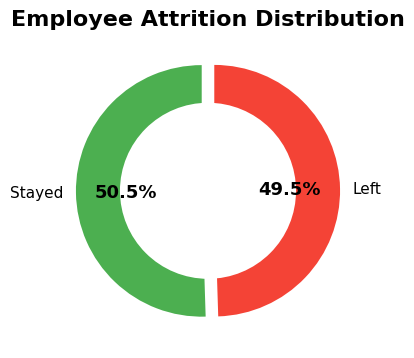

In [13]:
# 5.1. Attrition Distribution (Target Variable)
# Prepare data
attrition_counts = df['Attrition'].value_counts()
labels = ['Stayed', 'Left']
sizes = [attrition_counts[0], attrition_counts[1]]
colors = ['#4CAF50', '#F44336']  # Green and Red
explode = (0.05, 0.05)  # Slightly separate both slices

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 11, 'color': 'black'},
    wedgeprops=dict(width=0.4)  # Donut-style
)

# Title
plt.setp(autotexts, size=13, weight="bold")
ax.set_title("Employee Attrition Distribution", fontsize=16, fontweight='bold')

# Circle center for donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_13136\621345819.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gender', y='Attrition', data=df, palette='Set2', inner='box', linewidth=1.3)
C:\Users\hp\AppData\Local\Temp\ipykernel_13136\621345819.py:11: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


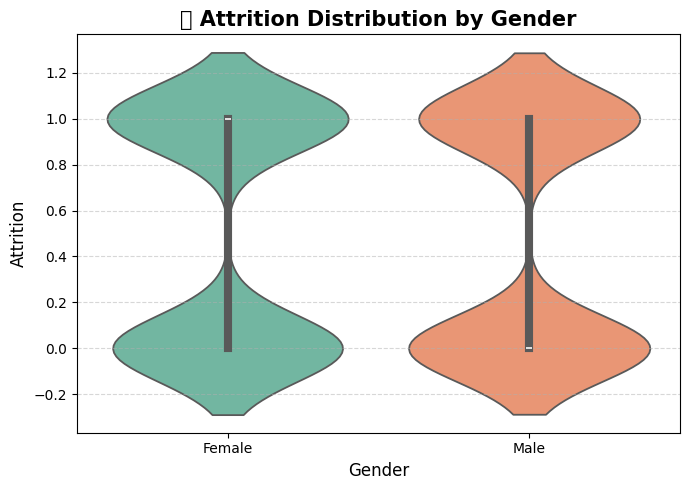

In [14]:
# 5.2. Attrition Rate by Gender
plt.figure(figsize=(7, 5))
sns.violinplot(x='Gender', y='Attrition', data=df, palette='Set2', inner='box', linewidth=1.3)

plt.title('🎻 Attrition Distribution by Gender', fontsize=15, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Attrition', fontsize=12)
plt.xticks([0, 1], ['Female', 'Male'])

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

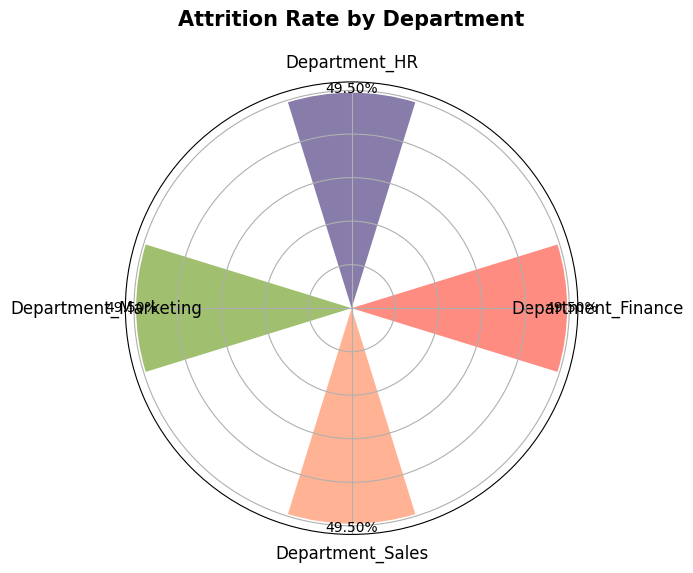

In [15]:
# 5.3. Attrition Rate by Department

# Step 1: Compute mean attrition per department
dept_cols = ['Department_Finance', 'Department_HR', 'Department_Marketing', 'Department_Sales']
dept_melt = df.melt(id_vars='Attrition', value_vars=dept_cols)
dept_attrition = dept_melt.groupby('variable')['Attrition'].mean().reset_index()

# Step 2: Plot in polar coordinates
labels = dept_attrition['variable']
values = dept_attrition['Attrition']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# Set up plot
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#FFA07A']

# Plot bars (no need to extend values or angles)
bars = ax.bar(angles, values, width=0.6, color=colors, alpha=0.8)

# Add labels
ax.set_xticks(angles)
ax.set_xticklabels(labels, fontsize=12)
ax.set_title("Attrition Rate by Department", fontsize=15, fontweight='bold', pad=20)
ax.set_yticklabels([])  # Hide radial ticks

# Annotate values
for angle, value in zip(angles, values):
    ax.text(angle, value + 0.01, f"{value:.2%}", ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_13136\3288006995.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Attrition', y='Satisfaction_Level', data=df, palette=box_colors)


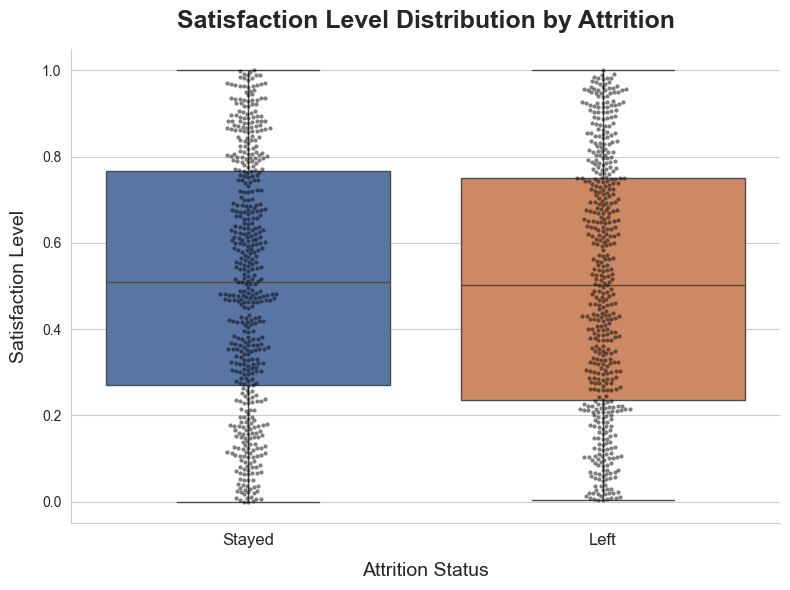

In [16]:
# 5.4. Satisfaction Level vs Attrition
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Boxplot with custom palette
box_colors = ['#4C72B0', '#DD8452']  # Blue and Orange tones for Stayed vs Left
ax = sns.boxplot(x='Attrition', y='Satisfaction_Level', data=df, palette=box_colors)

# Add swarmplot for individual points
sns.swarmplot(x='Attrition', y='Satisfaction_Level', data=df, 
              color='k', alpha=0.5, size=3, dodge=True)

# Title and labels with improved styling
plt.title('Satisfaction Level Distribution by Attrition', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Attrition Status', fontsize=14, labelpad=10)
plt.ylabel('Satisfaction Level', fontsize=14, labelpad=10)

# Custom x-ticks with labels
plt.xticks([0, 1], ['Stayed', 'Left'], fontsize=12)

# Optional: Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()

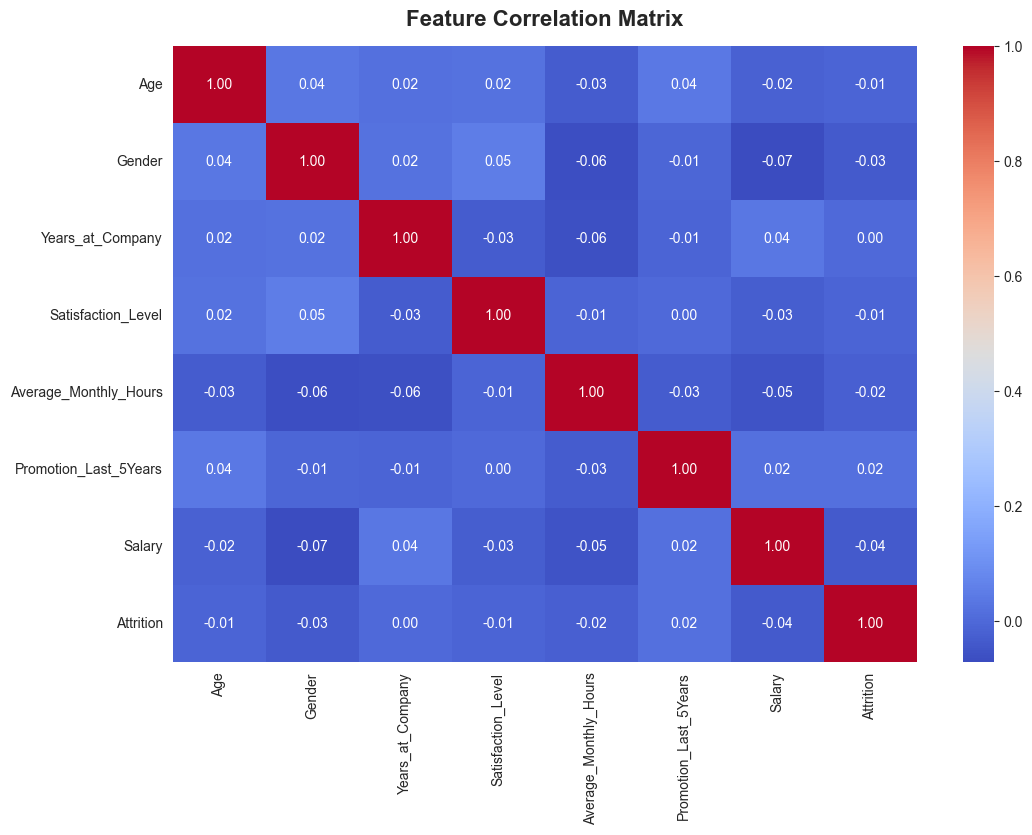

In [17]:
# 5.5. Correlation Heatmap

plt.figure(figsize=(12, 8))

# Select numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix and plot heatmap
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=15)
plt.show()

### Step 6: Feature Selection and Train-Test Split

In [18]:
# 6.1. Separate Features and Target

X = df.drop(columns=['Attrition'])
y = df['Attrition']

In [19]:
df['Attrition'].value_counts()

Attrition
0    505
1    495
Name: count, dtype: int64

In [20]:
# 6.2. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Step 7: Train a LightGBM Model

In [21]:
# 7.1. Import and Train LightGBM
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'seed': 42,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

# Train the model
num_round = 100

model = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[train_data, test_data],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.639329	valid_1's binary_logloss: 0.705148
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686997	valid_1's binary_logloss: 0.693157


In [22]:
# Predict probabilities
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.48

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.57      0.53       101
           1       0.47      0.38      0.42        99

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.48      0.48      0.48       200

ROC AUC Score: 0.5061506150615062


Confusion Matrix:
[[58 43]
 [61 38]]


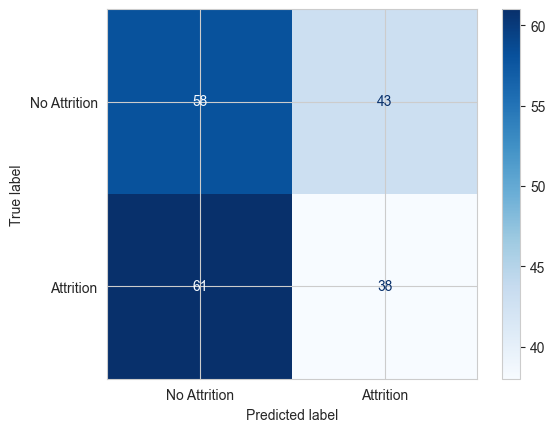

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# To plot it nicely:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Attrition', 'Attrition'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Feature Importance Plot

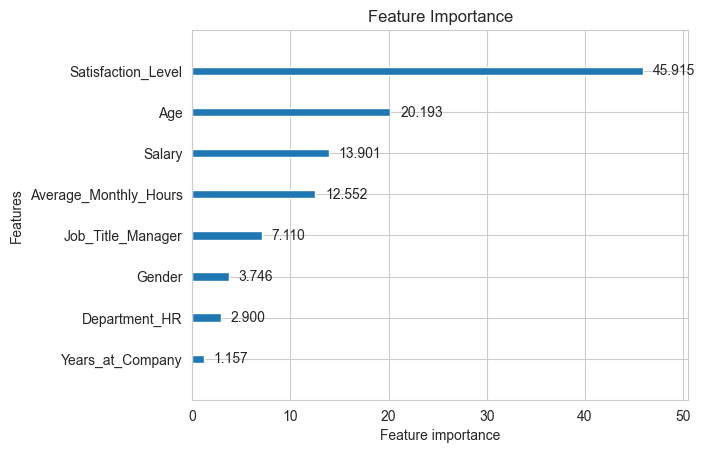

In [26]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

   ---------------------------------------- 0.0/544.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/544.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/544.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/544.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/544.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/544.2 kB ? eta -:--:--
   -------------------------------------- 544.2/544.2 kB 546.7 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


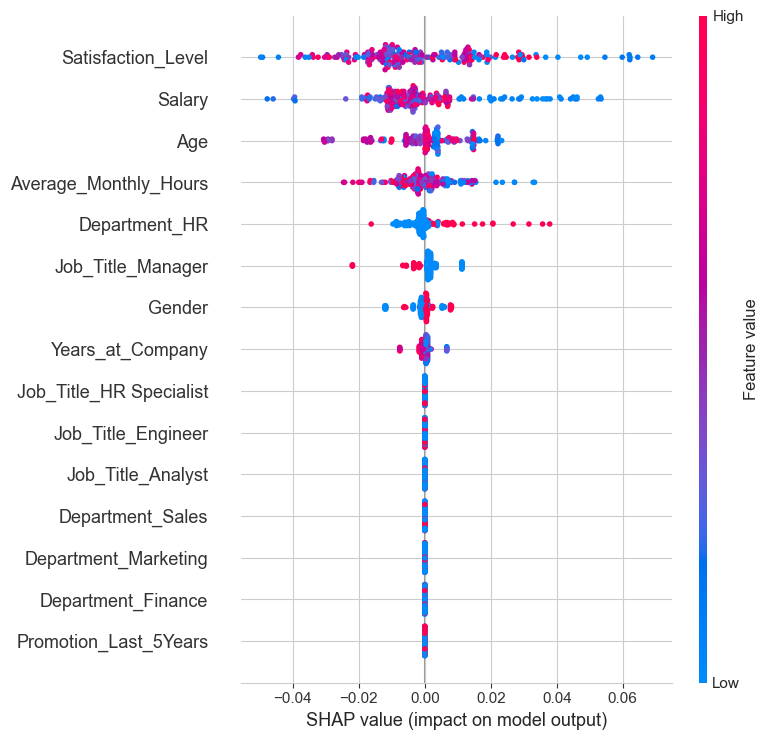

In [28]:
!pip install shap
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#### ROC Curve and AUC (Area Under Curve)

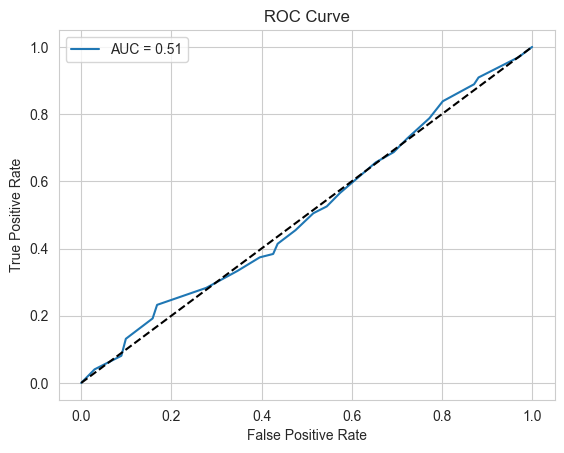

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()